# OT-guided regression

In [1]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from skimage.transform import downscale_local_mean
from scipy.ndimage import affine_transform
from scipy.stats import multivariate_normal
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from utils import pixel_dist_3d

### Create source frame

In [5]:
img_shape = (50, 25, 5)
n_pixels = img_shape[0] * img_shape[1] * img_shape[2]

# Grid for evaluating densities on
xg, yg, zg = np.mgrid[0:img_shape[0], 0:img_shape[1], 0:img_shape[2]]
grid = np.stack((xg, yg, zg), axis=-1)

# Means of Gaussian bumps in frames
mu_1 = np.array([20, 10, 3])
mu_2 = np.array([40, 10, 3])

# Covariance is same for both frames
cov = 5 * np.eye(3)

frame_1 = multivariate_normal.pdf(grid, mu_1, cov).reshape(img_shape)
frame_2 = multivariate_normal.pdf(grid, mu_2, cov).reshape(img_shape)

frame shape: (50, 25, 5)
num. pixels: 6250


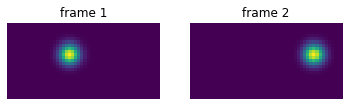

In [6]:
print(f'frame shape: {img_shape}')
print(f'num. pixels: {n_pixels}')

plt.subplot(121)
plt.imshow(np.max(frame_1, 2).T);
plt.title('frame 1')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.max(frame_2, 2).T);
plt.title('frame 2')
plt.axis('off');

### Compute optimal transport plan between frames

In [9]:
# Normalized pixel distance matrix 
M_nn = pixel_dist_3d(*img_shape)
M = M_nn / np.median(M_nn)

# Entropic regularization parameter
reg = 1e-3

# Compute transport plan
P = ot.sinkhorn(frame_1.flatten(), frame_2.flatten(), M, reg, verbose=False)